# Алгоритм разбиения бизнесс процесса на подпроцессы по журналу событий основанный на кластеризации трасс
В данном блокноте представлен алгоритм разбиения бизнесс процесса на подпроцессы по журналу событий и его применение 
на журнале событий:
1. [Hospital log](https://data.4tu.nl/articles/_/12716513/1)

## Оглавление:
1. Подгатовка данных
2. Применение алгоритма



#### 1. Подгатовка данных

Для начала подключим необходимые библиотеки

In [3]:
import numpy as np
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
event_log_xes = pm4py.read_xes("../Data/Hospital_log/Hospital_log.xes")
event_log_csv = pm4py.convert_to_dataframe(event_log_xes)
event_log_csv.to_csv("../Data/Hospital_log/Hospital_log.csv", index=False)

/home/anna/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/home/anna/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1143/1143 [00:07<00:00, 158.15it/s]


Теперь уже откроем журнал событий с помощью pandas

In [4]:
df = pd.read_csv("../Data/Hospital_log/Hospital_log.csv")
df.head(5)

/tmp/ipykernel_3924/2987412286.py:1: DtypeWarning: Columns (28,36,37,40,42,44,47,48,49,50,54,55,56,57,58,68,69,70,71,75,80,81,82,83,88,89,90,91,93,94,95,96,97,98,99,105,107,108,120,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/Hospital_log/Hospital_log.csv")


,org:group,Number of executions,Specialism code,concept:name,Producer code,Section,Activity code,time:timestamp,lifecycle:transition,case:End date,...,case:Treatment code:14,case:Treatment code:15,case:Diagnosis:15,case:Diagnosis:14,case:Diagnosis:11,case:Diagnosis:13,case:Diagnosis:12,case:Diagnosis code:14,case:Diagnosis code:13,case:Diagnosis code:15
0,Radiotherapy,1,61,1e consult poliklinisch,SRTH,Section 5,410100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Radiotherapy,1,61,administratief tarief - eerste pol,SRTH,Section 5,419100,2005-01-03 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nursing ward,1,7,verlosk.-gynaec. korte kaart kosten-out,SGEH,Section 2,10107,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Obstetrics & Gynaecology clinic,1,7,echografie - genitalia interna,SGEC,Section 2,339486E,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nursing ward,1,7,1e consult poliklinisch,SGEH,Section 2,410100,2005-01-05 00:00:00+00:00,complete,2006-01-04 23:45:36+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(150291, 128)

In [4]:
df["concept:name"].unique()

array(['1e consult poliklinisch',
       'administratief tarief       - eerste pol',
       'verlosk.-gynaec. korte kaart kosten-out',
       'echografie  - genitalia interna',
       'simulator - gebruik voor aanvang megavol',
       'behandeltijd - eenheid t3 - megavolt',
       'teletherapie - megavolt fotonen bestrali',
       'aanname laboratoriumonderzoek', 'ureum',
       'hemoglobine foto-elektrisch', 'creatinine',
       'natrium vlamfotometrisch', 'kalium potentiometrisch',
       'leukocyten tellen elektronisch',
       'trombocyten tellen - elektronisch', 'ordertarief',
       'ligdagen - alle spec.beh.kinderg.-reval.', 'sediment - spoed',
       'bacteriologisch onderzoek met kweek -nie',
       'resistentiebepalingen - 5 bepalingen',
       'hepatitis-b surface antigeen confirmatie',
       'urine onderzoek - kwalitatief', '190021 klinische opname a002',
       '190205 klasse 3b        a205', 'sgot - asat kinetisch',
       'sgpt - alat kinetisch', 'melkzuurdehydrogenase 

In [5]:
code_case, unique_case = pd.factorize(df["case:concept:name"])
code_activity, unique_activity = pd.factorize(df["concept:name"])

In [6]:
print("Count of cases:", len(unique_case))
print("Count of activities:", len(unique_activity))


Count of cases: 1143
Count of activities: 624


In [7]:
df["code_case"] = code_case
df["code_activity"] = code_activity
grouped_df = df.groupby(df["code_case"])["code_activity"].agg(list).reset_index()
grouped_df["len"] = grouped_df["code_activity"].apply(lambda x : len(x))
grouped_df

,code_case,code_activity,len
0,0,"[0, 1, 2, 3, 0, 1, 4, 5, 6, 7, 7, 8, 9, 10, 11...",75
1,1,"[31, 0, 1, 2, 32, 1, 32, 16, 7, 7, 7, 33, 34, ...",239
2,2,"[31, 32, 32, 1, 32, 32, 32, 32, 66, 32, 32, 32...",25
3,3,"[31, 7, 21, 15, 32, 1, 32, 32, 66, 32, 32, 32,...",22
4,4,"[2, 73, 7, 7, 7, 74, 75, 76, 8, 9, 10, 77, 11,...",185
...,...,...,...
1138,1138,"[3, 7, 7, 7, 74, 75, 76, 8, 9, 10, 77, 11, 12,...",31
1139,1139,"[98, 7, 7, 74, 75, 76, 8, 9, 10, 77, 11, 12, 2...",26
1140,1140,"[7, 7, 7, 74, 75, 76, 8, 9, 10, 77, 11, 12, 24...",27
1141,1141,"[134, 7, 7, 7, 74, 75, 76, 8, 9, 10, 77, 11, 1...",30


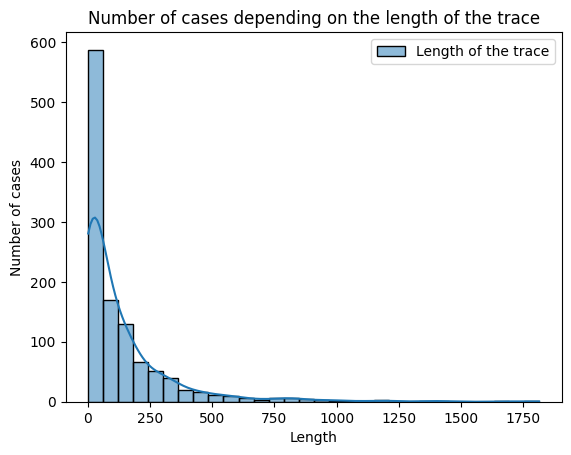

In [8]:
grouped_df_graph = grouped_df.drop(["code_case", "code_activity"], axis=1)
grouped_df_graph = grouped_df_graph.rename(columns={'len': 'Length of the trace'})
plot = sns.histplot(grouped_df_graph, bins=30, kde=True, color="skyblue")
plt.title("Number of cases depending on the length of the trace")
plt.xlabel("Length")
plt.ylabel("Number of cases")
plt.show()

In [9]:
mean_length = grouped_df_graph["Length of the trace"].mean()
mode_length = grouped_df_graph["Length of the trace"].mode()[0]
print("Средняя длинна слова:", mean_length)
print("Самая часто встречающаяся длинна слова:", mode_length)

Средняя длинна слова: 131.48818897637796
Самая часто встречающаяся длинна слова: 2


#### 2. Применение алгоритма

In [1]:
import LogSplitter
import Metrics

In [11]:
for_activity_df = df.groupby(df["code_case"])["concept:name"].agg(list).reset_index()
corpus = for_activity_df['concept:name'].to_list()

In [12]:
model = LogSplitter.LogSplitter(2)
model.fit(corpus)

In [13]:
max_dif, min_dif, average = 0, 10000000, 0
for i in range(10, 100, 10):
    temp_dif = 0
    for j in range(5):

        model.transform(for_activity_df, name_id='code_case', name_traces='concept:name', trace_parts=i/100, choose_func=2)
        temp_dif += abs( model.class_to_is[0] - model.class_to_is[1])
    
    temp_dif /= 5

    print(i, model.len_part, temp_dif)
    max_dif = max(max_dif, temp_dif)
    min_dif = min(min_dif, temp_dif)
    average += temp_dif

print("min_dif:", min_dif)
print("max_dif:", max_dif)
print("average_dif:", average / 9)

10 13 317.8
20 26 93.8
30 39 125.8
40 52 309.4
50 65 318.2
60 78 320.6
70 92 326.6
80 105 323.8
90 118 329.0
min_dif: 93.8
max_dif: 329.0
average_dif: 273.8888888888889


In [17]:
for i in range(2, 5):
    model = LogSplitter.LogSplitter(i)
    model.fit(corpus)

    model.transform(for_activity_df, name_id='code_case', name_traces='concept:name', trace_parts=20/100, choose_func=2)
    model.save_as_csv(df, "../Test/Hospital_log/" + str(i) + "/1/")

    model.transform(for_activity_df, name_id='code_case', name_traces='concept:name', trace_parts=30/100, choose_func=2)
    model.save_as_csv(df, "../Test/Hospital_log/" + str(i) + "/2/")


Код данной ячейки выполняется очень долго (больше часа)

In [ ]:
metric = Metrics.Metric()
result = pd.DataFrame(columns=['Metric', '1', '2', '3', '4'])
e_cardoso_average = list()
e_cardoso_w_average = list()
pt_cd_average = list()
pt_cd_w_average = list()

e_cardoso_average.append("Average E-Cardoso")
e_cardoso_w_average.append("Weighted average E-Cardoso")
pt_cd_average.append("Average PT/CD")
pt_cd_w_average.append("Weighted average PT/CD")

t_df = [pd.read_csv("../Data/Hospital_log/Hospital_log.csv") for _ in range(1)]
t_df[0]["time:timestamp"] = pd.to_datetime(t_df[0]["time:timestamp"], format='ISO8601')
t_df[0]["case:concept:name"] = t_df[0]["case:concept:name"].astype(str)
ans, e_average, e_w_average = metric.e_cardoso(t_df)
ans, pt_average, pt_w_average = metric.pt_cd(t_df)

e_cardoso_average.append(e_average.copy())
e_cardoso_w_average.append(e_w_average.copy())
pt_cd_average.append(pt_average.copy())
pt_cd_w_average.append(pt_w_average.copy())


for i in range(2, 5):
    t_df = [pd.read_csv("../Test/Hospital_log/" + str(i) + "/1/" + str(j) + ".csv") for j in range(i)]
    for temp in t_df:
        temp["time:timestamp"] = pd.to_datetime(temp["time:timestamp"], format='ISO8601')
        temp["case:concept:name"] = temp["case:concept:name"].astype(str)
    ans, e_average, e_w_average = metric.e_cardoso(t_df)
    ans, pt_average, pt_w_average = metric.pt_cd(t_df)

    e_cardoso_average.append(e_average.copy())
    e_cardoso_w_average.append(e_w_average.copy())
    pt_cd_average.append(pt_average.copy())
    pt_cd_w_average.append(pt_w_average.copy())



In [14]:
result = pd.DataFrame(columns=['Metric', '1', '2', '3', '4'])

In [15]:
result.loc[len(result)] = e_cardoso_average
result.loc[len(result)] = e_cardoso_w_average
result.loc[len(result)] = pt_cd_average
result.loc[len(result)] = pt_cd_w_average

In [16]:
result

,Metric,1,2,3,4
0,Average E-Cardoso,677.000000,511.500000,560.666667,515.750000
1,Weighted average E-Cardoso,677.000000,553.676724,691.986566,657.732502
2,Average PT/CD,2.740929,2.722262,2.757943,2.818761
3,Weighted average PT/CD,2.740929,2.713544,2.778311,2.790801


Код данной ячейки выполняется очень долго (больше часа)

In [ ]:
metric = Metrics.Metric()
result = pd.DataFrame(columns=['Metric', '1', '2', '3', '4'])

e_cardoso_average.append("Average E-Cardoso")
e_cardoso_w_average.append("Weighted average E-Cardoso")
pt_cd_average.append("Average PT/CD")
pt_cd_w_average.append("Weighted average PT/CD")

e_cardoso_average.append(e_cardoso_average[1])
e_cardoso_w_average.append(e_cardoso_w_average[1])
pt_cd_average.append(pt_cd_average[1])
pt_cd_w_average.append(pt_cd_w_average[1])


for i in range(2, 5):
    t_df = [pd.read_csv("../Test/Hospital_log/" + str(i) + "/2/" + str(j) + ".csv") for j in range(i)]
    for temp in t_df:
        temp["time:timestamp"] = pd.to_datetime(temp["time:timestamp"], format='ISO8601')
        temp["case:concept:name"] = temp["case:concept:name"].astype(str)
    ans, e_average, e_w_average = metric.e_cardoso(t_df)
    ans, pt_average, pt_w_average = metric.pt_cd(t_df)

    e_cardoso_average.append(e_average.copy())
    e_cardoso_w_average.append(e_w_average.copy())
    pt_cd_average.append(pt_average.copy())
    pt_cd_w_average.append(pt_w_average.copy())


In [22]:
result.loc[len(result)] = e_cardoso_average[5:]
result.loc[len(result)] = e_cardoso_w_average[5:]
result.loc[len(result)] = pt_cd_average[5:]
result.loc[len(result)] = pt_cd_w_average[5:]

In [23]:
result

,Metric,1,2,3,4
0,Average E-Cardoso,677.000000,458.000000,560.333333,545.250000
1,Weighted average E-Cardoso,677.000000,536.449367,733.419032,727.588736
2,Average PT/CD,2.740929,2.708560,2.815239,2.837627
3,Weighted average PT/CD,2.740929,2.695065,2.792193,2.829202
